In [96]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from galpy.potential import MiyamotoNagaiPotential, HernquistPotential, NFWPotential
from galpy.actionAngle import estimateDeltaStaeckel
from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

In [2]:
machine = 'mac'
machine = 'magny'

if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
else:
    raise NotADirectoryError

In [23]:
halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"
level = 4
#### action time evolution
startnr = 76
endnr = 77

lookback_time_Gyr = []
jR_mean = []
jR_std = []
jz_mean = []
jz_std = []
lz_mean = []
lz_std = []
#jR_all = []]
#jz_all = []
#lz_all = []
for snap_number in range(startnr, endnr, 1):
    print(snap_number)
    s, sf = eat_snap_and_fof(level, halo_number, snap_number, snappath, loadonlytype=[4], 
        haloid=0, galradfac=0.1, verbose=False, rotate_disk=0, use_principal_axis=0, euler_rotation=0, use_cold_gas_spin=0, do_rotation=0) 

    # Clean negative and zero values of gmet to avoid RuntimeErrors
    # later on (e.g. dividing by zero)
    #s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 ) 

    snap_time = s.cosmology_get_lookback_time_from_a( s.time, is_flat=True )
    lookback_time_Gyr.append(snap_time)
    infile = '/home/extmilan/masterthesis/files/actions_merger_73_9728_parts_snap_' +str(snap_number)+ '_nonsmoothed_pot_params.txt'
    ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)



76
[ 16.47659492  15.88422775  17.06827354]


In [24]:
level = 4
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
else:
    raise NotADirectoryError
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(76,77,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )

level   : 4
halo    : 24
snapnr  : 76
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 16.47659492  15.88422775  17.06827354]
Found 817842 stars.
Rotated pos.
Rotated vel.

galrad  : 0.014894464612007143
redshift: 1.074457894547674
time    : 0.4820536500780824
center  : [ 0.  0.  0.]



In [61]:
i_all, = np.where((s.type == 4) & (s.r() >0.) & (s.halo == 0))
i_all_GCs = np.isin(s.id, ids)
(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, i_all)
(R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, i_all)


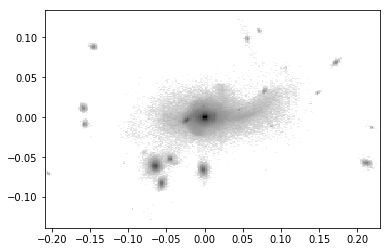

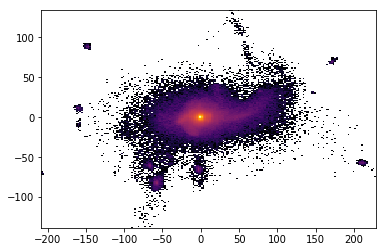

In [64]:
plt.hist2d(s.pos[i_all, 2], s.pos[i_all, 1], 201, norm = LogNorm(), cmap = plt.cm.binary)
plt.show()
plt.hist2d(x_kpc, y_kpc, 201, norm = LogNorm(), cmap = plt.cm.inferno)
plt.aspect('equal')
plt.show()

x < 50kpc & x > 20 kpc
-10 < y < 0

In [74]:
cond0, = np.where((s.type == 4) & (s.r() >0.) & (s.halo == 0) & (s.subhalo == 0))
i_streams, = np.where( (x_kpc > 45.) & (x_kpc < 90.) & (y_kpc > 0.) & (y_kpc < 25.) )

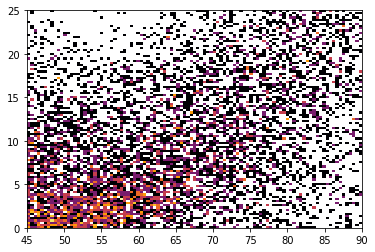

In [75]:
plt.hist2d(x_kpc[i_streams], y_kpc[i_streams], 101, norm = LogNorm(), cmap = plt.cm.inferno)
plt.show()

In [97]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc  / _REFR0_kpc
    b_MND  = b_MND_kpc  / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc   / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
     
    return [disk,halo,bulge]


#for a in range(50):


In [98]:
startsnap = 76
endsnap = 76
actionmatrix = np.array([]) # should result in: action * GC * time
lookback_time_Gyr = []
used_IDs = s.id[i_all]
for snapnr in range(startsnap, endsnap + 1,1):
    i_snap = snapnr - startsnap 
    snapnnum, R0_kpc, v0_kms, a_MND_kpc, b_MND_kpc, a_HB_kpc, a_NFWH_kpc, v0_MND_kms, v0_HB_kms, v0_NFWH_kms = np.loadtxt(filedir + 'potential_params/pot_snap_' + str(snapnr))
    n_MND   = v0_MND_kms**2  / v0_kms**2
    n_HB    = v0_HB_kms**2   / v0_kms**2
    n_NFWH  = v0_NFWH_kms**2 / v0_kms**2

    fix_R0_kpc = R0_kpc
    fix_v0_kms = v0_kms
    print(n_MND,n_HB,n_NFWH)
    a_MND_kpc = 1.
    print("load stars of snap {0}".format(snapnr))
    s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
        haloid=0, galradfac=0.1, verbose=True) 

    # Clean negative and zero values of gmet to avoid RuntimeErrors
    # later on (e.g. dividing by zero)
    s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )

    snap_time = s.cosmology_get_lookback_time_from_a( s.time, is_flat=True )
    lookback_time_Gyr.append(snap_time)
    #pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc)

    try:
        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc)
    except:
        print('For snap {} no potential can be set up.'.format(int(snapnr)))
        filler1 = np.full(len(used_IDs), np.nan)
        filler2 = np.full(len(used_IDs), np.nan)
        actionmatrix = np.append(actionmatrix, [filler1, filler2, filler1])
        
        continue


    i_test_GCs = np.isin(s.id, used_IDs)
    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, i_test_GCs)
    # convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / fix_R0_kpc, vR_kms / fix_v0_kms, vphi_kms / fix_v0_kms, z_kpc / fix_R0_kpc, vz_kms / fix_v0_kms

    # estimate Delta of the Staeckel potential
    delta = 0.45
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
    # CHECK HOW BIG INFLUENCE OF DELTA IS


    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )


    jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(num_GCs), np.zeros(num_GCs), np.zeros(num_GCs), np.zeros(num_GCs)
    savedIDs = np.zeros(num_GCs)
    IDs_notworking = []


    for test_i, item in enumerate(used_IDs):
        '''        
        if (test_i % 1000) == 0:
            print(datetime.datetime.now().time())
            print(test_i)
        '''
        try: 
            jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
            r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
            savedIDs[test_i] = item
        except(ValueError, UnboundError):
            IDs_notworking.append(item)
            continue
    print('numbers of GCs wo actions:', len(IDs_notworking))
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * fix_R0_kpc * fix_v0_kms, lz_galpy * fix_R0_kpc * fix_v0_kms, jz_galpy * fix_R0_kpc * fix_v0_kms
    
    # just pick result values of particles of which I actually could calculate actions
    nonsurvivor_id_mask = np.isin(used_IDs, IDs_notworking)
    survivor_id_mask = np.isin(used_IDs, savedIDs)
    
    jR_kpckms = np.where(survivor_id_mask, jR_kpckms, np.nan)
    jz_kpckms = np.where(survivor_id_mask, jz_kpckms, np.nan)
    lz_kpckms = np.where(survivor_id_mask, lz_kpckms, np.nan)
    
    #jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
    #r_kpc = r_kpc[survivor_id_mask]
    #print(jR_kpckms)
    #survivor_IDs = used_IDs[survivor_id_mask]
    #actionmatrix = np.append(actionmatrix, [jR_kpckms, lz_kpckms, jz_kpckms])
    
    ### TO DO:  if GC wo action add -99 values

0.0934504557382 0.141845403649 0.764704140613
load stars of snap 76
[ 16.47659492  15.88422775  17.06827354]
Found 817842 stars.
Rotated pos.
Rotated vel.

galrad  : 0.014894464612007143
redshift: 1.074457894547674
time    : 0.4820536500780824
center  : [ 0.  0.  0.]



NameError: name 'actionAngleStaeckel' is not defined

In [ ]:
from galpy.actionAngle import actionAngleStaeckel
# set up the actionAngleStaeckel object
aAS = actionAngleStaeckel(
        pot   = pot_galpy,  # potential
        delta = delta,      # focal length of confocal coordinate system
        c     = True        # use C code (for speed)
        )

num_GCs = len(used_IDs)

jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(num_GCs), np.zeros(num_GCs), np.zeros(num_GCs), np.zeros(num_GCs)
savedIDs = np.zeros(num_GCs)
IDs_notworking = []


for test_i, item in enumerate(used_IDs):
    '''        
    if (test_i % 1000) == 0:
        print(datetime.datetime.now().time())
        print(test_i)
    '''
    try: 
        jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
        r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
        savedIDs[test_i] = item
    except(ValueError, UnboundError):
        IDs_notworking.append(item)
        continue
print('numbers of GCs wo actions:', len(IDs_notworking))
jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * fix_R0_kpc * fix_v0_kms, lz_galpy * fix_R0_kpc * fix_v0_kms, jz_galpy * fix_R0_kpc * fix_v0_kms

# just pick result values of particles of which I actually could calculate actions
nonsurvivor_id_mask = np.isin(used_IDs, IDs_notworking)
survivor_id_mask = np.isin(used_IDs, savedIDs)

jR_kpckms = np.where(survivor_id_mask, jR_kpckms, np.nan)
jz_kpckms = np.where(survivor_id_mask, jz_kpckms, np.nan)
lz_kpckms = np.where(survivor_id_mask, lz_kpckms, np.nan)

#jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
#r_kpc = r_kpc[survivor_id_mask]
#print(jR_kpckms)
#survivor_IDs = used_IDs[survivor_id_mask]
#actionmatrix = np.append(actionmatrix, [jR_kpckms, lz_kpckms, jz_kpckms])

### TO DO:  if GC wo action add -99 values

In [ ]:
fig,ax = plt.subplots()

stream_ID = s.id[i_streams]
stream_GCs = np.isin(ids,stream_ID)
ax.hist2d(jR_kpckms[jR_kpckms<10000.], jz_kpckms[jR_kpckms<10000.], 101, norm= LogNorm(), cmap = plt.cm.gray)
ax.plot(jR_kpckms[stream_GCs], jz_kpckms[stream_GCs], 'r.')
#ax.set_xlim(0.,5000.)
plt.show()